# Ronde van Vlaanderen - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In this notebook, the application of DBSCAN as a hierarchical clustering algorithm is presented with data from a specific competition (Ronde van Vlaanderen) and the cilists who participated in it over the years. This experiment aims at clustering the records in the global dataset according to the most relevant features without separating the information into races and cyclists.

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

In [21]:
ronde_dataset = pd.read_csv('../../data/complete_dataset_no_outliers.csv').drop(columns=['profile', 'uci_points', 'mean_cyclist_cp', 'mean_delta', 'mean_position', 'raw_position', 'points'])
ronde_dataset = ronde_dataset[ronde_dataset['race_name'] == 'Ronde van Vlaanderen']
ronde_dataset = ronde_dataset.select_dtypes(include=['number'])
ronde_dataset = ronde_dataset.dropna().reset_index(drop=True)

# drop colums from PCA and UMAP analisis
ronde_dataset = ronde_dataset.drop(['length', 'startlist_quality', 'position', 'delta', 'race_year', 'race_prestige', 'num_participants'], axis=1)

ronde_dataset.info()
columns_to_use = ronde_dataset.columns

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(ronde_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   birth_year                   762 non-null    int64  
 1   weight                       762 non-null    float64
 2   height                       762 non-null    float64
 3   climb_total                  762 non-null    float64
 4   cyclist_age                  762 non-null    int64  
 5   cyclist_bmi                  762 non-null    float64
 6   climb_percentage             762 non-null    float64
 7   cyclist_climb_power          762 non-null    float64
 8   race_physical_effort         762 non-null    float64
 9   previous_mean_position       762 non-null    float64
 10  previous_mean_delta          762 non-null    float64
 11  previous_mean_cp             762 non-null    float64
 12  cyclist_previous_experience  762 non-null    float64
dtypes: float64(11), int6

In [22]:
'''
# Step 1: Calculate the mean delta for each cyclist
mean_delta = dataset.groupby('cyclist_url')['delta'].mean()
mean_bmi = dataset.groupby('cyclist_url')['cyclist_bmi'].mean()
mean_height = dataset.groupby('cyclist_url')['height'].mean()
mean_cp = dataset.groupby('cyclist_url')['cyclist_climb_power'].mean()

# Step 2: Map the mean delta back to each row
dataset['mean_delta'] = dataset['cyclist_url'].map(mean_delta)
dataset['mean_bmi'] = dataset['cyclist_url'].map(mean_bmi)
dataset['mean_height'] = dataset['cyclist_url'].map(mean_height)
dataset['mean_cp'] = dataset['cyclist_url'].map(mean_cp)
'''

"\n# Step 1: Calculate the mean delta for each cyclist\nmean_delta = dataset.groupby('cyclist_url')['delta'].mean()\nmean_bmi = dataset.groupby('cyclist_url')['cyclist_bmi'].mean()\nmean_height = dataset.groupby('cyclist_url')['height'].mean()\nmean_cp = dataset.groupby('cyclist_url')['cyclist_climb_power'].mean()\n\n# Step 2: Map the mean delta back to each row\ndataset['mean_delta'] = dataset['cyclist_url'].map(mean_delta)\ndataset['mean_bmi'] = dataset['cyclist_url'].map(mean_bmi)\ndataset['mean_height'] = dataset['cyclist_url'].map(mean_height)\ndataset['mean_cp'] = dataset['cyclist_url'].map(mean_cp)\n"

Thanks to the following model selection process, the two parameters of the ‘DBSCAN’ algorithm (‘eps’ and ‘min_samples’) were selected in the context of this case study. Of the options studied in the process, the evaluation was made according to the trade-off between the number of clusters identified and silhouette score.

Each iteration of the model selection process starts with setting the ‘min_points’ parameter, studied in the range 2-20. For each of these alternatives, the optimal value of the ‘eps’ parameter is identified through the identification of the knee-point in the curve defined by the points (k-th distance, index).

Our Knee Method implementation:

- We compute the 𝑘-distance for each point:
    - Choose a value for 𝑘, a tipical choice should be to set to 𝑘 = min_points − 1, where min_points is the minimum number of points required to form a dense region (DBSCAN parameter fixed in the model selection iteration). 
    - For each point in the dataset, we calculate the distance to its 𝑘-th nearest neighbor (𝑘-distance).
- We sort the 𝑘-distances:
    - Arrange all the points by their 𝑘-distance in a 𝑘-distance plot, where the x-axis is the points (sorted) and the y-axis is their 𝑘-distance.
- Plot the 𝑘-distance graph
- Identify the "knee" in the plot: The y-axis typically increases gradually at first and then sharply increases, forming a curve. The knee corresponds to the point of maximum curvature in the graph. It is the location where the slope changes most significantly. Intuitively, it separates the "dense" regions (gradual slope) from the "sparse" regions (steep slope) in the dataset.


To automate the process of knee detection, we relied on the kneed library (KneeLocator).


#### Model Selection

In [23]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 20)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []



for i, value in enumerate(min_points):
    k = value - 1 #standard value? TODO: check this
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")
    
    if(kneedle.knee is None):
        optimal_eps.append(None) 
        optimal_index.append(None)  
        silhouette_scores.append(None)
        continue
    
    # Get the knee (selecting automatically the optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    ronde_dataset['cluster'] = clusters
    number_of_clusters = ronde_dataset['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    if(number_of_clusters < 3): # Considering that a cluster (label -1) is that of outliers, to compute silhouette we need at least 3 clusters here
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(ronde_dataset[ronde_dataset['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

,min_points,optimal_eps,optimal_index,cluster_count,silhouette_score
0,2,2.685376,748,4,0.576764
1,3,2.819030,746,3,0.613328
2,4,2.845134,736,3,0.623902
3,5,3.116723,741,3,0.596880
4,6,3.351880,743,3,0.596880
5,7,3.473066,743,2,NaN
6,8,3.859564,748,2,NaN
7,9,3.866111,745,2,NaN
8,10,3.910752,744,2,NaN
9,11,4.418072,751,2,NaN


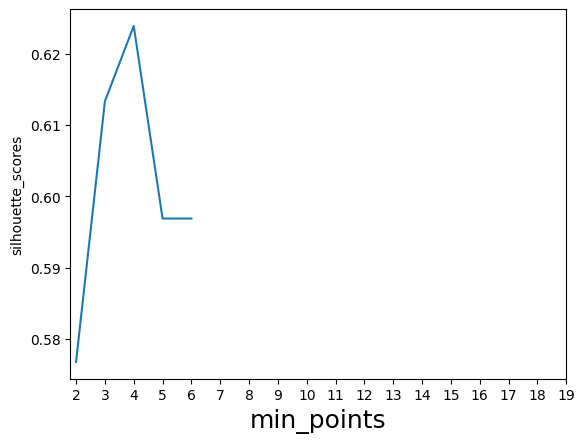

In [24]:
x = model_selection_df[model_selection_df['cluster_count'] > 2]['min_points']
y = model_selection_df[model_selection_df['cluster_count'] > 2]['silhouette_score']

plt.plot(x, y)
plt.ylabel('silhouette_scores')
plt.xlabel('min_points', fontsize=18)
plt.xticks(min_points)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Chosen Parameter Clustering

(289941,)
(762, 762)
Optimal epsilon (eps): 3.91075181842585
Knee point index: 744


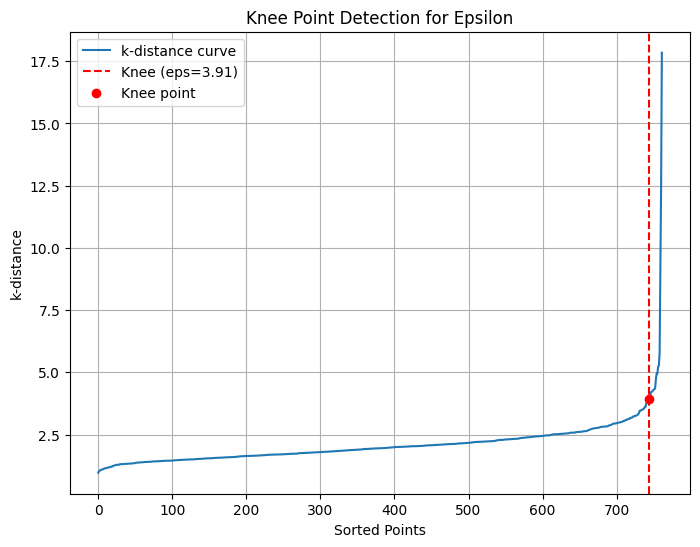

In [6]:
min_points = 10

dist = pdist(data_scaled, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 #standard value?
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

#### Selection of best eps

In [7]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

In [8]:
# Add cluster labels to the data
ronde_dataset['cluster'] = clusters

# Display cluster distribution
print(ronde_dataset['cluster'].value_counts())
print(ronde_dataset.head())

cluster
 0    756
-1      6
Name: count, dtype: int64
   birth_year  weight  height  climb_total  cyclist_age  cyclist_bmi  \
0        1970    71.0   183.0        1.535           30    21.200991   
1        1959    70.0   181.0        3.515           37    21.366869   
2        1993    69.0   180.0        2.118           24    21.296296   
3        1993    69.0   180.0        2.014           27    21.296296   
4        1993    69.0   180.0        2.198           28    21.296296   

   climb_percentage  cyclist_climb_power  race_physical_effort  \
0          0.005706             0.000018              0.093056   
1          0.013067             0.000017              0.213091   
2          0.008146             0.000051              0.124104   
3          0.008278             0.000440              0.055214   
4          0.008643             0.000061              0.125968   

   previous_mean_position  previous_mean_delta  previous_mean_cp  \
0                0.498257           542.811594  

In [9]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0]), array([  6, 756]))

In [10]:
# Identify outliers (cluster label -1)
outliers = ronde_dataset[ronde_dataset['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 6


In [11]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = ronde_dataset.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
           birth_year              weight                height            \
                mean       std      mean       std        mean       std   
cluster                                                                    
-1       1969.833333  6.080022  73.50000  8.642916  180.000000  8.414274   
 0       1983.489418  7.232644  71.77381  3.922059  181.861111  4.844115   

        climb_total           cyclist_age            ... race_physical_effort  \
               mean       std        mean       std  ...                 mean   
cluster                                              ...                        
-1         3.190833  1.374008   29.000000  5.176872  ...             0.190358   
 0         2.213659  0.494694   29.361111  3.333637  ...             0.127976   

                  previous_mean_position           previous_mean_delta  \
              std                   mean       std                mean   
cluster                                     

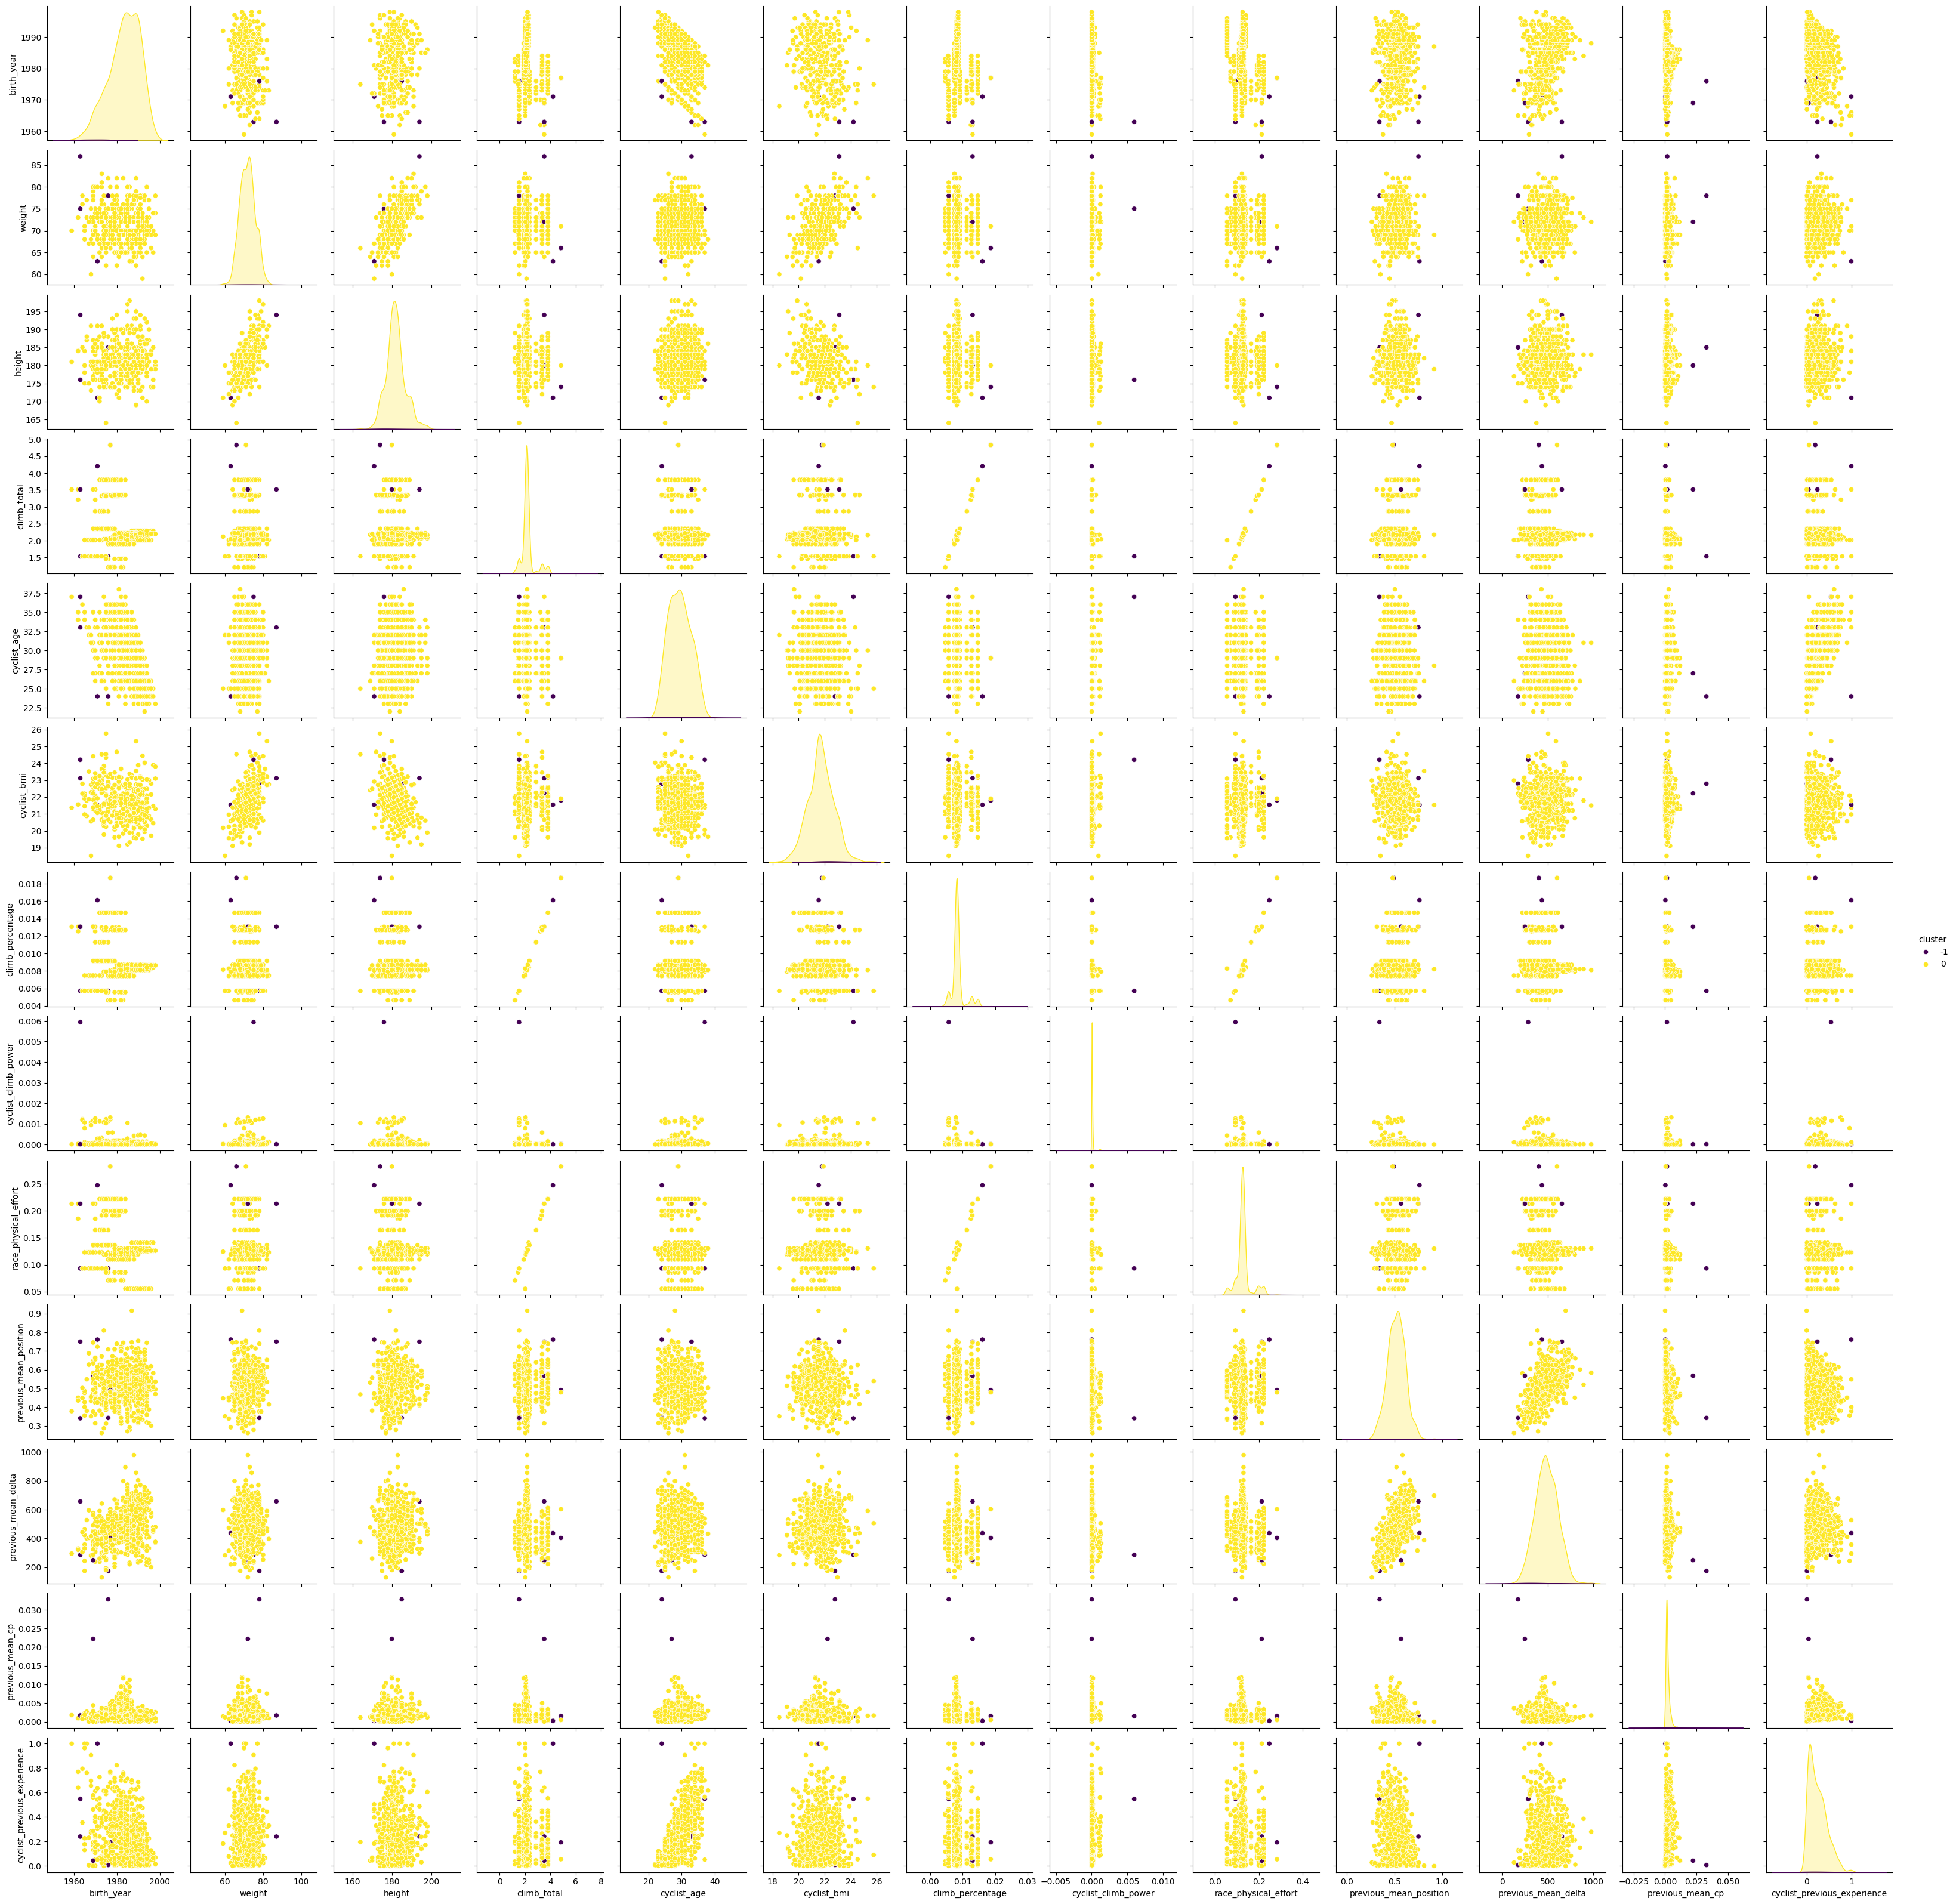

In [14]:
# Pair plot for a subset of columns
data_subset = ronde_dataset[list(columns_to_use) + ['cluster']]
sns.pairplot(data_subset, hue='cluster', palette='viridis')
plt.show()

In [ ]:
%matplotlib widget

x = ronde_dataset['position']  # Prima feature
y = ronde_dataset['length']  # Seconda feature
z = ronde_dataset['race_physical_effort']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=ronde_dataset['cluster'], cmap='viridis', s=50)
ax.set_xlabel('position')
ax.set_ylabel('length')
ax.set_zlabel('race_physical_effort')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

In [ ]:
%matplotlib widget

x = ronde_dataset['cyclist_bmi']  # Prima feature
y = ronde_dataset['cyclist_age']  # Seconda feature
z = ronde_dataset['cyclist_climb_power']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=ronde_dataset['cluster'], cmap='viridis', s=50)
ax.set_xlabel('cyclist_bmi')
ax.set_ylabel('cyclist_age')
ax.set_zlabel('cyclist_climb_power')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

Analysing the plots, we can see that density-based clustering through DBSCAN revealed the presence of three relevant clusters.
In particular, looking at the data with respect to the size of the ‘position’, ‘lenght’, "race_physical_effort" and "cyclist_climb_power" features, we can clearly observe the result of DBSCAN's behaviour, with clusters of varying shapes and densely packed within them.

The clusters can be analysed as follows (colour references and labels in the plots):
- yellow (2) : records associated to cyclists classified in stages of less than average length and low required physical effort 
- green (1): records clearly representative of cyclists-performances demonstrating above-average climb power (clearly visible from the two-dimensional pair-scatter-plots with this attribute in evidence)
- dark blue (-1): outliers
- blue (0): remaining records

In [ ]:
data_scaled = scaler.fit_transform(ronde_dataset[ronde_dataset['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))